In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

from emccd_detect import emccd_detect
meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-12-27 11:49:15,785	INFO worker.py:1636 -- Started a local Ray instance.


1.3624486320346218e-17 sr
	Flux for wavelength 8.130e-07 m: 3.998e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 3.840e+08 ph / (s m2)
	Flux for wavelength 8.370e-07 m: 3.691e+08 ph / (s m2)
Total flux: 1.153e+09 ph / (s m2)


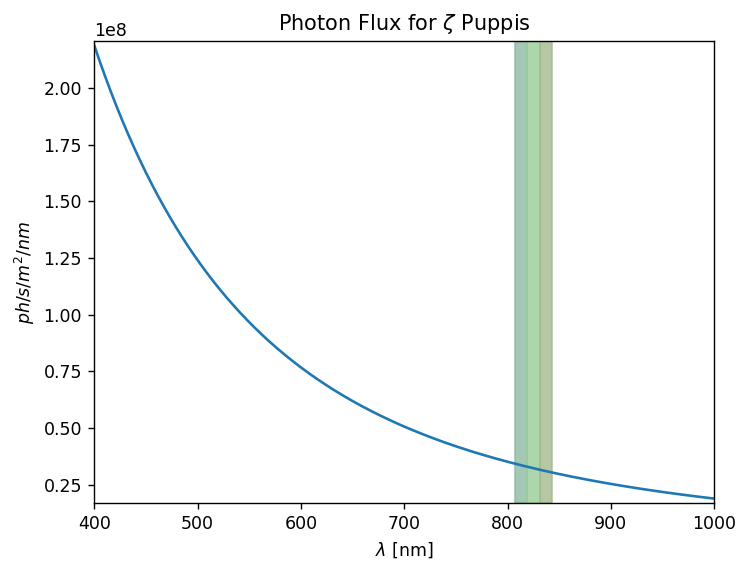

In [2]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 825e-9*u.m

nwaves = 3
bandwidth = 2.9/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
print(f'Total flux: {total_flux:.3e}')

In [3]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

In [4]:
em_gain = 200
full_well_image=60000.  # e-
full_well_serial=100000.  # e-
#status=1,
dark_current=0.0028  # e-/pix/s
dark_current=1.5/3600  # e-/pix/s
cic=0.02  # e-/pix/frame
read_noise=120.  # e-/pix/frame
bias=500.  # e-
qe=0.5
cr_rate=0.  # hits/cm^2/s
pixel_pitch=13e-6  # m
eperdn=1 #7.,
nbits=16
numel_gain_register=604

emccd = emccd_detect.EMCCDDetect(em_gain=em_gain,
                                    full_well_image=full_well_image,  # e-
                                    full_well_serial=full_well_serial,  # e-
                                    #status=status,
                                    dark_current=dark_current,  # e-/pix/s
                                    cic=cic,  # e-/pix/frame
                                    read_noise=read_noise,  # e-/pix/frame
                                    bias=bias,  # e-
                                    qe=qe,
                                    cr_rate=cr_rate,  # hits/cm^2/s
                                    pixel_pitch=pixel_pitch,  # m
                                    eperdn=eperdn,
                                    nbits=nbits,
                                    numel_gain_register=numel_gain_register,
                                    meta_path=meta_path
                                    )

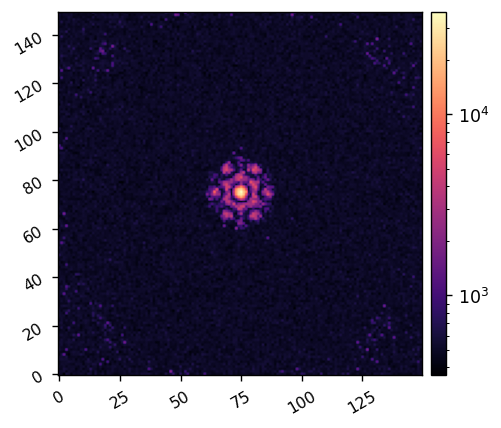

Adding photon noise for frame 1.
Simulating EMCCD frame 1.
Adding photon noise for frame 2.
Simulating EMCCD frame 2.
Adding photon noise for frame 3.
Simulating EMCCD frame 3.
Adding photon noise for frame 4.
Simulating EMCCD frame 4.
Adding photon noise for frame 5.
Simulating EMCCD frame 5.
Adding photon noise for frame 6.
Simulating EMCCD frame 6.
Adding photon noise for frame 7.
Simulating EMCCD frame 7.
Adding photon noise for frame 8.
Simulating EMCCD frame 8.
Adding photon noise for frame 9.
Simulating EMCCD frame 9.
Adding photon noise for frame 10.
Simulating EMCCD frame 10.


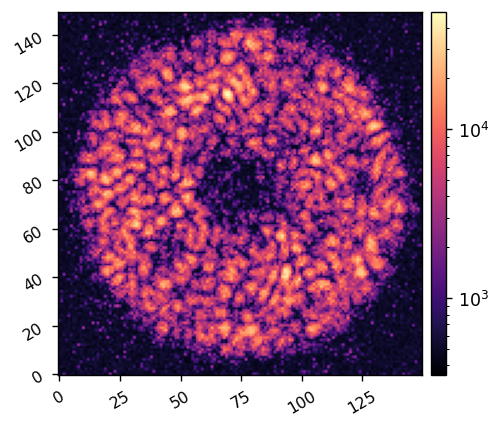

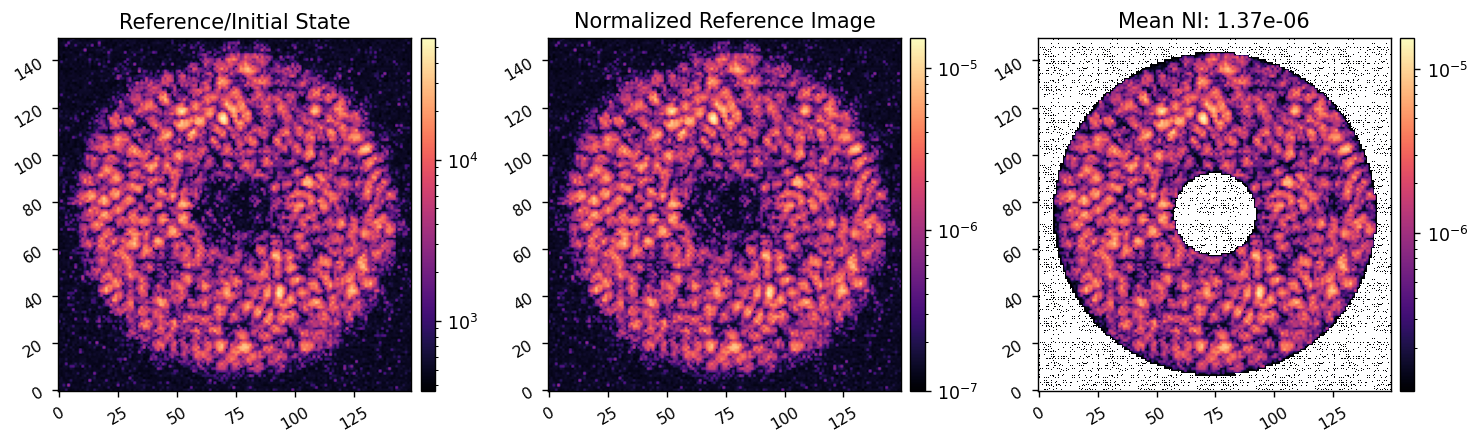

In [6]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, dm1_ref=dm1_flat, dm2_ref=dm2_flat)

mode.use_photon_noise = True
mode.EMCCD = emccd
# mode.subtract_bias = True

unocc_exp_time = 0.00001
unocc_em_gain = 250

mode.set_actor_attr('use_fpm',False)
mode.Nframes = 10
mode.exp_time = unocc_exp_time
mode.EMCCD.em_gain = unocc_em_gain

ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, lognorm=True)

mode.set_actor_attr('use_fpm',True)
mode.Nframes = 10
mode.exp_time = 0.5
mode.EMCCD.em_gain = 500

occ_im = mode.snap(quiet=False)
imshow1(occ_im, lognorm=True)

mode.normalize = True
mode.Imax_ref = xp.max(ref_unocc_im)
mode.exp_time_ref = unocc_exp_time
mode.em_gain_ref = unocc_em_gain

ref_im = mode.snap()
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)
mean_ni = xp.mean(ref_im[control_mask])
imshow3(ref_im/mode.norm_factor, ref_im, ref_im*control_mask, 
        'Reference/Initial State', 
        'Normalized Reference Image',
        f'Mean NI: {mean_ni:.2e}',
        lognorm=True)


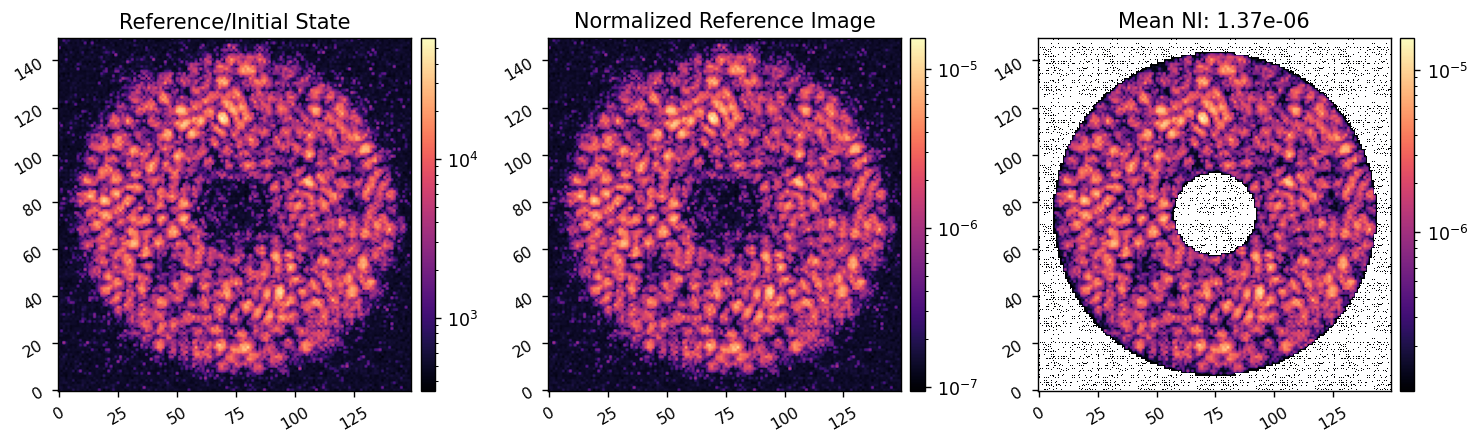

In [8]:
ref_im = mode.snap()
mean_ni = xp.mean(ref_im[control_mask])
imshow3(ref_im/mode.norm_factor, ref_im, ref_im*control_mask, 
        'Reference/Initial State', 
        'Normalized Reference Image',
        f'Mean NI: {mean_ni:.2e}',
        lognorm=True)

# Create calibration and probe modes

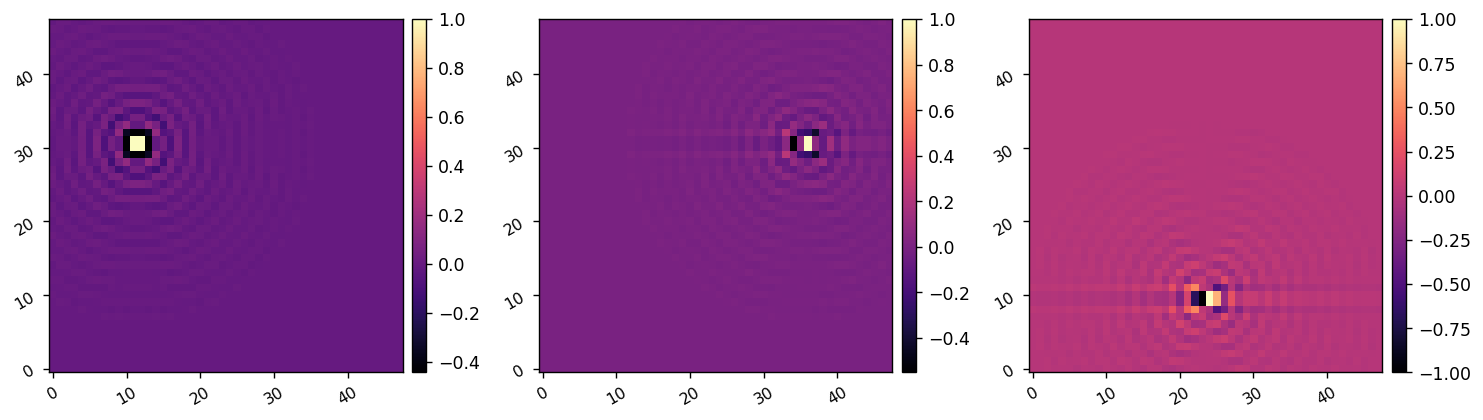

In [9]:
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.5,
                                          shift=[(-12,7), (12,7),(0,-14), (0,0)], nprobes=3,
                                           use_weighting=True,)

imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

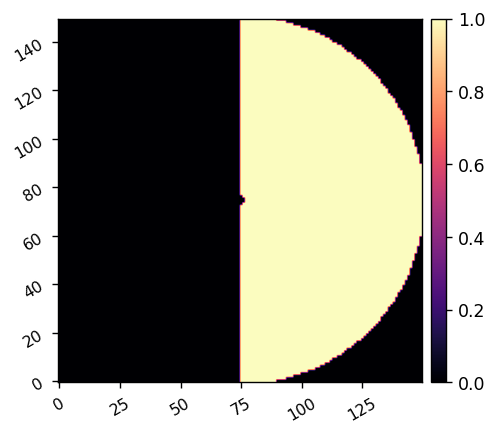

(3480, 4608)


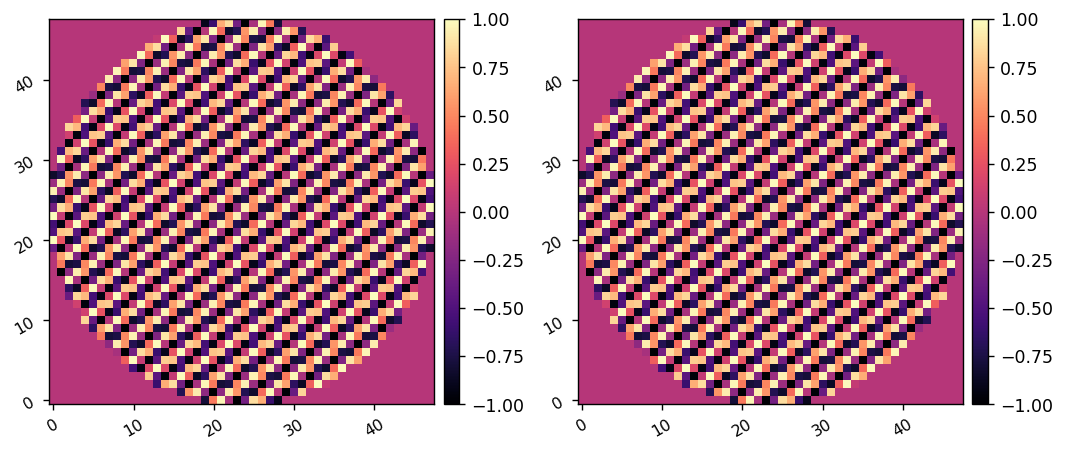

(3480, 4608)


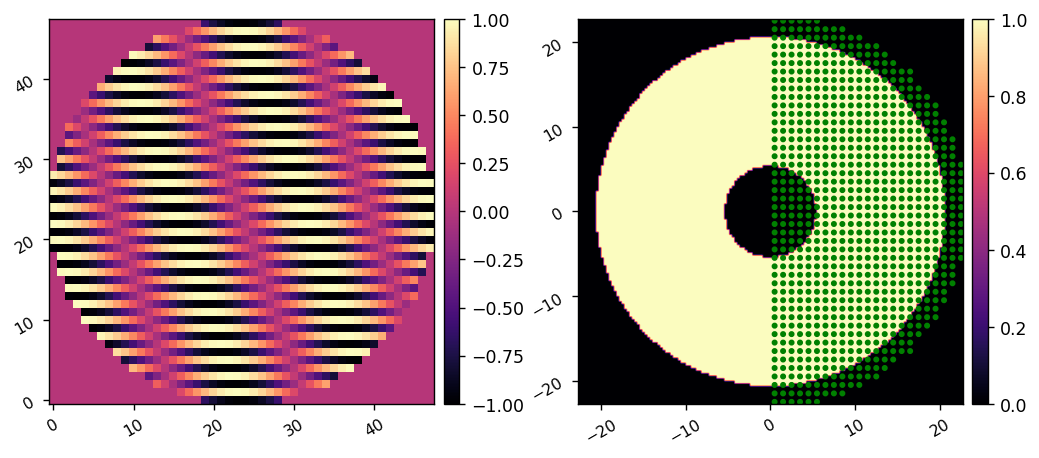

In [10]:
fourier_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=0.5, outer_radius=23, edge=0, plot=True)
calib_modes, fs = utils.create_fourier_modes(mode, fourier_mask, fourier_sampling=1, ndms=2, return_fs=True)
Nfourier = calib_modes.shape[0]//2
print(calib_modes.shape)
i = 100
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), 
        calib_modes[i+Nfourier,mode.Nact**2:].reshape(mode.Nact,mode.Nact))

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
print(calib_modes.shape)
imshow2(calib_modes[1, :mode.Nact**2].reshape(mode.Nact,mode.Nact), control_mask, 
             patches2=patches, pxscl2=mode.psf_pixelscale_lamD)

In [41]:
calib_modes.shape[0]//2/2

870.0

In [38]:
fs.shape

(870, 2)

In [14]:
reload(utils)

scale_factors = []
for i in range(fs.shape[0]):
    mode_extent = xp.sqrt(fs[i][0]**2 + fs[i][1]**2)
    if mode_extent<2:
        factor = 4
    elif mode_extent>2 and mode_extent<3:
        factor = 1
    elif mode_extent>3 and mode_extent<4:
        factor = 3/4
    elif mode_extent>4 and mode_extent<6:
        factor = 1/2
    elif mode_extent>6 and mode_extent<9:
        factor = 1/5
    elif mode_extent>9 and mode_extent<10:
        factor = 1/4
    elif mode_extent>10 and mode_extent<15:
        factor = 1/5
    elif mode_extent>15 and mode_extent<18:
        factor = 1/5
    elif mode_extent>18 and mode_extent<20:
        factor = 1/3
    elif mode_extent>20 and mode_extent<22:
        factor = 1/2
    elif mode_extent>22 and mode_extent<23:
        factor = 1
    elif mode_extent>23:
        factor = 2
    scale_factors.append(factor)
scale_factors = np.array(scale_factors)

scale_factors = np.concatenate([scale_factors,scale_factors, scale_factors, scale_factors])
print(scale_factors.shape)

(3480,)


(3480,)


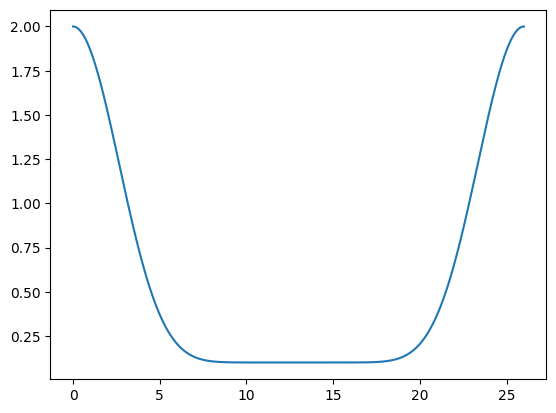

In [47]:
fmax = 26
x = np.linspace(0,fmax, 1000)
min_scale_factor = 1/10
max_scale_factor = 2
factors = (max_scale_factor - min_scale_factor)*np.cos(2*np.pi/fmax/2*x)**10 + min_scale_factor

plt.plot(x, factors)

scale_factors = []
for i in range(fs.shape[0]):
    mode_extent = np.sqrt(fs[i][0]**2 + fs[i][1]**2)
    closest_index = np.argmin(np.abs(x-mode_extent))
    scale_factors.append(factors[closest_index])
scale_factors = np.array(scale_factors)
scale_factors = np.concatenate([scale_factors,scale_factors, scale_factors, scale_factors])
print(scale_factors.shape)

In [ ]:
mode.normalize = True
mode.reset_dms()
mode.EMCCD.em_gain = 300
mode.exp_time = 0.1
mode.Nframes = 5

calib_amp = 5e-9
probe_amp = 25e-9

mode.add_dm1(probe_amp*probe_modes[0])
probed_im = mode.snap()/mode.norm_factor
mode.add_dm1(-probe_amp*probe_modes[0])

for i in range(411, 435):
        dm_mode = calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact)
        scaled_calib_amp = calib_amp * scale_factors[i]
        # print(scale_factors[i], scaled_calib_amp)

        mode.add_dm1(scaled_calib_amp*dm_mode)
        mode.add_dm1(probe_amp*probe_modes[0])
        im = mode.snap()
        mode.add_dm1(-probe_amp*probe_modes[0])
        mode.add_dm1(-scaled_calib_amp*dm_mode)

        imshow3(scaled_calib_amp*dm_mode, im/mode.norm_factor, im/mode.norm_factor - probed_im,
                f'F = {xp.sqrt(fs[i][0]**2 + fs[i][1]**2):.2f},\nScale Factor = {scale_factors[i]:.2f}\nCalib Amp = {scaled_calib_amp:.2e}', 
                f'{xp.max(im/mode.norm_factor)}', 
                lognorm2=True, lognorm3=True)
# i = 411
# i = 412
# i = 413
# i = 414
# i = 415
# i = 416
# i = 417
# i = 418
# i = 419
# i = 420
# i = 421
# i = 422
# i = 423
# i = 427
# i = 430
# i = 434
# i = 435
# dm_mode = calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact)
# scaled_calib_amp = calib_amp * scale_factors[i]
# # print(scale_factors[i], scaled_calib_amp)

# mode.add_dm1(scaled_calib_amp*dm_mode)
# mode.add_dm1(probe_amp*probe_modes[0])
# im = mode.snap()
# mode.add_dm1(-probe_amp*probe_modes[0])
# mode.add_dm1(-scaled_calib_amp*dm_mode)

# imshow3(scaled_calib_amp*dm_mode, im/mode.norm_factor, im, 
#         f'F = {xp.sqrt(fs[i][0]**2 + fs[i][1]**2):.2f},\nScale Factor = {scale_factors[i]:.2f}\nCalib Amp = {scaled_calib_amp:.2e}', 
#         f'{xp.max(im/mode.norm_factor)}', 
#         lognorm2=True, lognorm3=True)
# imshow2(im, im-ref_im, lognorm1=True)

In [98]:
2**16, xp.max(im)


(65536, array(65369.4))

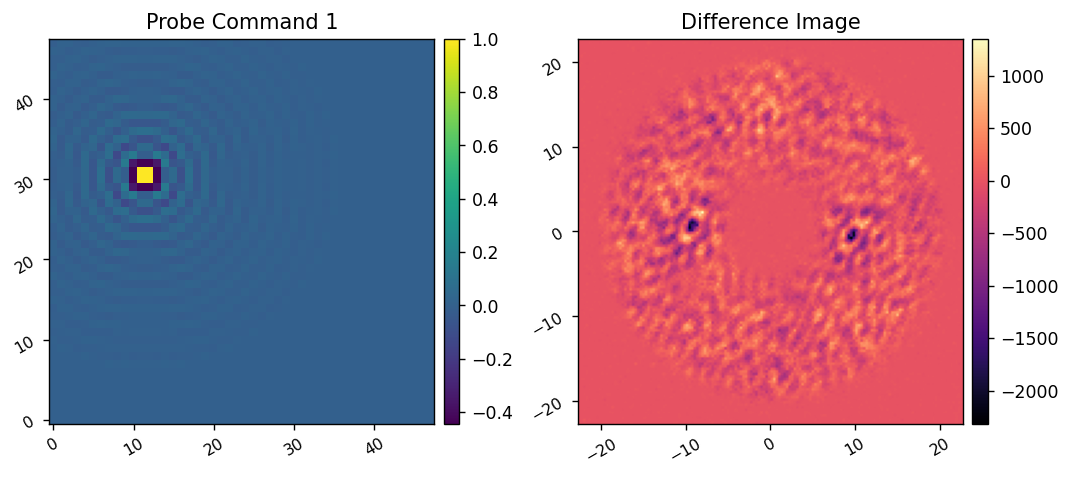

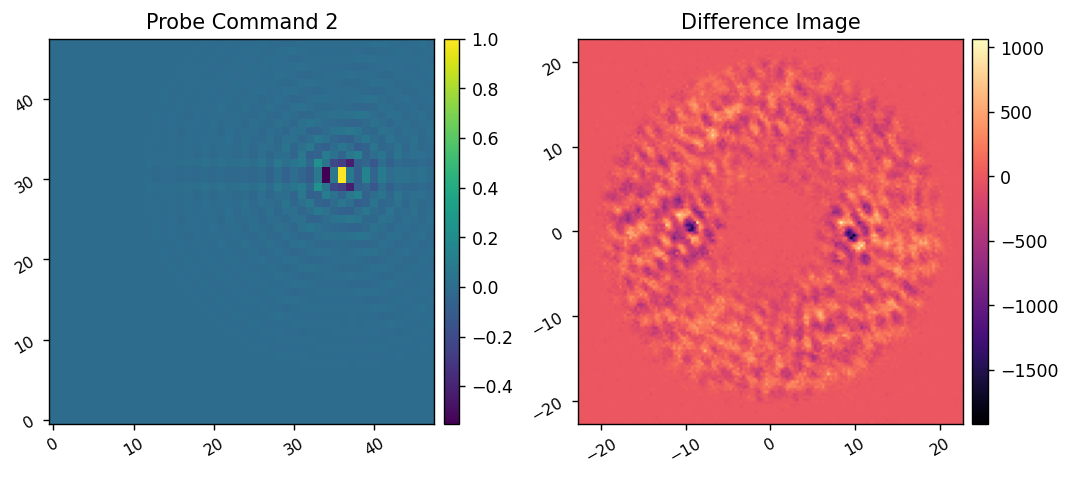

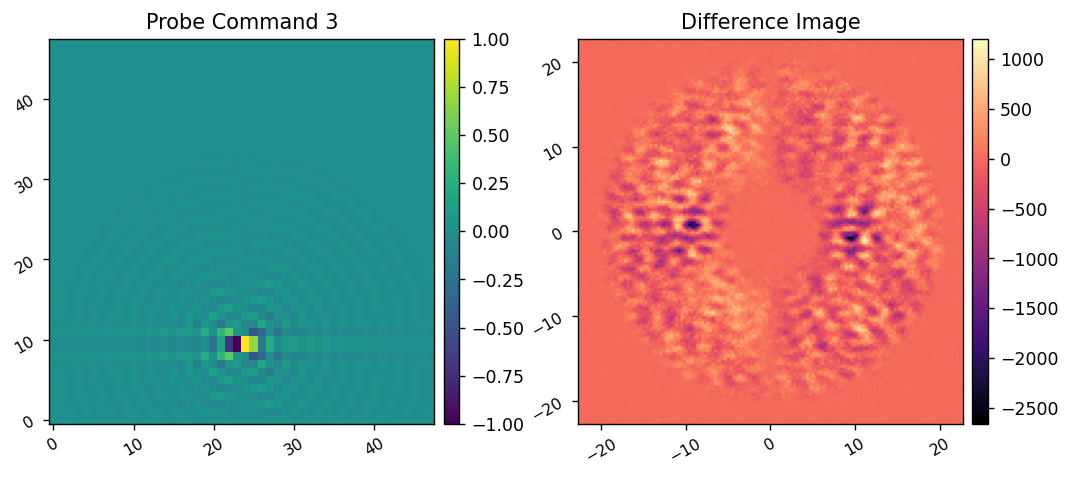

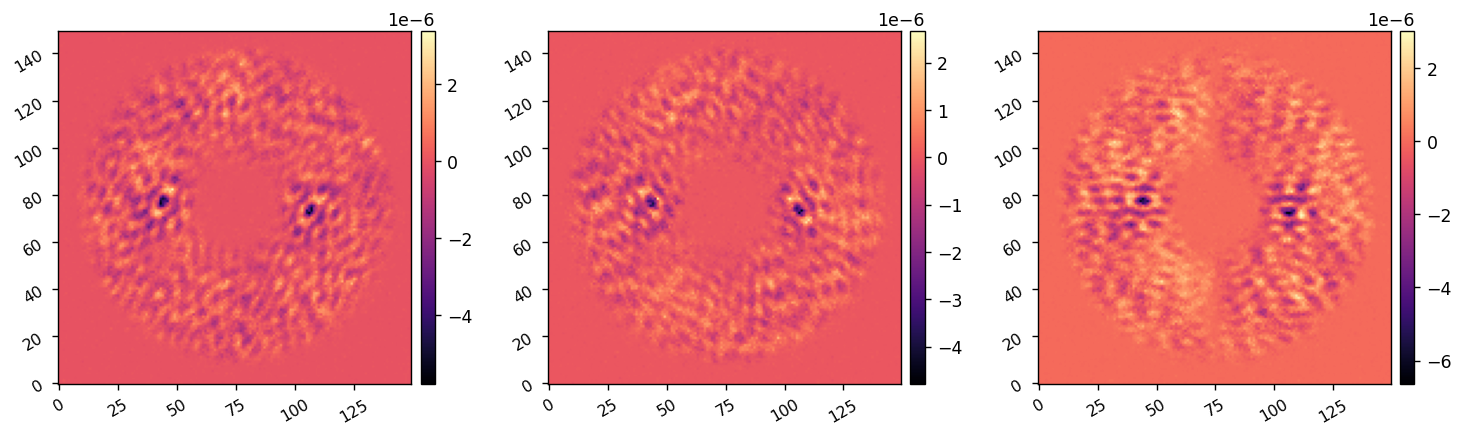

In [15]:
reload(iefc_2dm)
mode.normalize = True
mode.reset_dms()
mode.EMCCD.em_gain = 300
mode.exp_time = 0.1
mode.Nframes = 5

i = 420
probe_amp = 25e-9
calib_amp = 5e-9
scaled_calib_amp = scale_factors[i] * calib_amp

dm_mode = calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact)

mode.add_dm1(scaled_calib_amp*dm_mode)
differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = 2*scaled_calib_amp*differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
mode.add_dm1(-scaled_calib_amp*dm_mode)

imshow3(ims[0], ims[1], ims[2])


In [17]:
calib_amps

array([5.e-09, 5.e-09, 5.e-09, 5.e-09, 5.e-09, 5.e-09])

Calibrating iEFC...


	Calibrated mode 3/3 in 35.455s
Calibration complete.


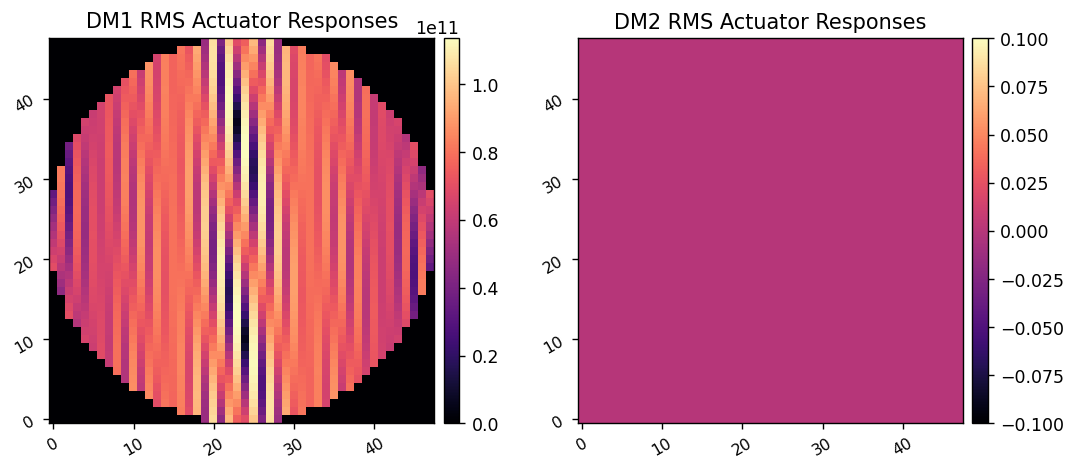

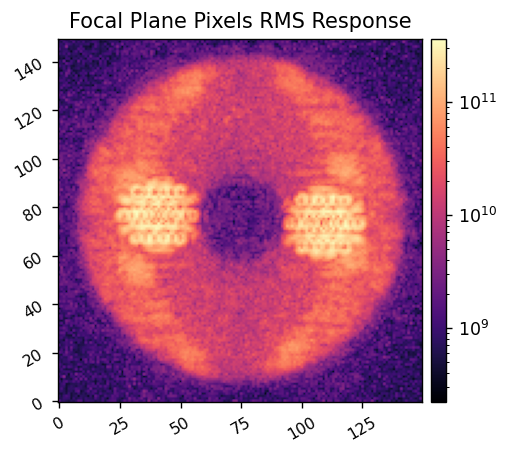

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20231224.fits


In [16]:
reload(iefc_2dm)

# calib_amp = 5e-9

response_matrix, response_cube, calib_amps = iefc_2dm.calibrate(mode, 
                                                                control_mask,
                                                                probe_amp, probe_modes, 
                                                                calib_amp, calib_modes[420:423], 
                                                                return_all=True, 
            #                                                     plot_responses=False,
                                                            )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
# utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [11]:
date = 20230912
date = 20230913
date = 20230918
date = 20230920
# date = 20230921
date = 20231017
date = 20231220 # hadamard modes
date = 20231222 # fourier modes
date = 20231224 # fourier modes 2
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_band4b_emccd_response_matrix_{date}.fits'))
response_info = fits.getheader(response_dir/f'spc_wide_band4b_emccd_response_matrix_{date}.fits')
display(response_info)
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_825_poke_modes_response_cube_{date}.fits'))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3480                                                  
NAXIS2  =                40572                                                  
EM_GAIN =                  300                                                  
NFRAMES =                    5                                                  
EXP_TIME=                  0.1                                                  

In [21]:
xp.mean(response_matrix.dot(xp.array(calib_modes)), axis=0).shape

(4608,)

5436012629257.338


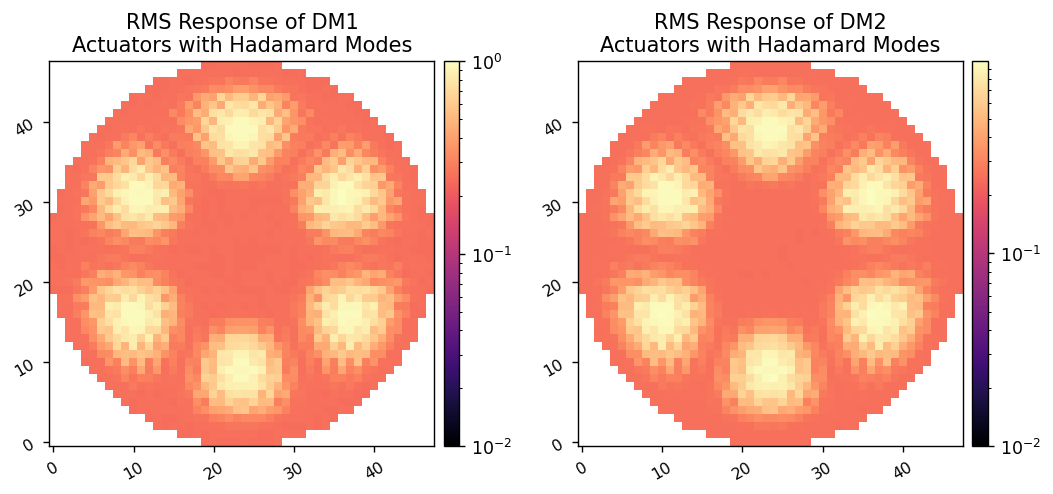

In [12]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )


# Run IEFC

In [21]:
mode.reset_dms()
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])

# imshow2(mode.get_dm1(), mode.get_dm2())

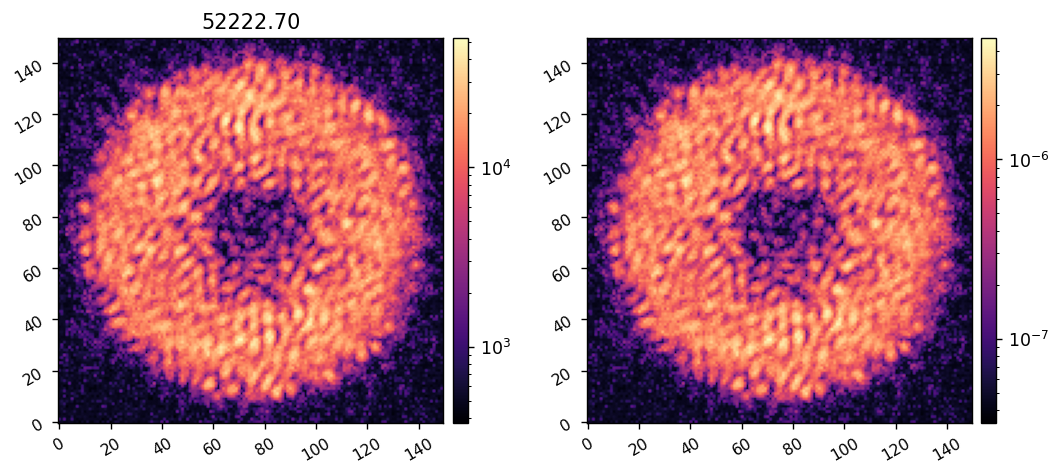

In [45]:
mode.normalize = True

mode.exp_time = 3
mode.Nframes = 10
mode.EMCCD.em_gain = 250

probe_amp = 10e-9

mode.add_dm1(probe_amp*probe_modes[0])
im = mode.snap()
mode.add_dm1(-probe_amp*probe_modes[0])

imshow2(im/mode.norm_factor, im, f'{xp.max(im/mode.norm_factor):.2f}', lognorm=True,)

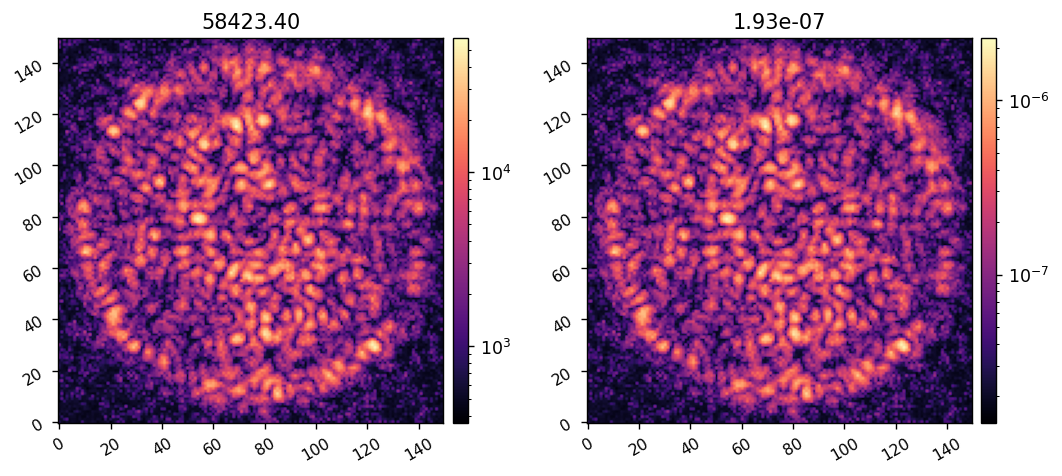

In [47]:

mode.exp_time = 7
mode.Nframes = 10
mode.EMCCD.em_gain = 250

im = mode.snap()
mean_ni = xp.mean(im[control_mask])
imshow2(im/mode.norm_factor, im, 
        f'{xp.max(im/mode.norm_factor):.2f}',
        f'{mean_ni:.2e}',
         lognorm=True,)


In [42]:
reg_fun = utils.beta_reg
reg_conds = -3

Running iEFC...
	Closed-loop iteration 16 / 18


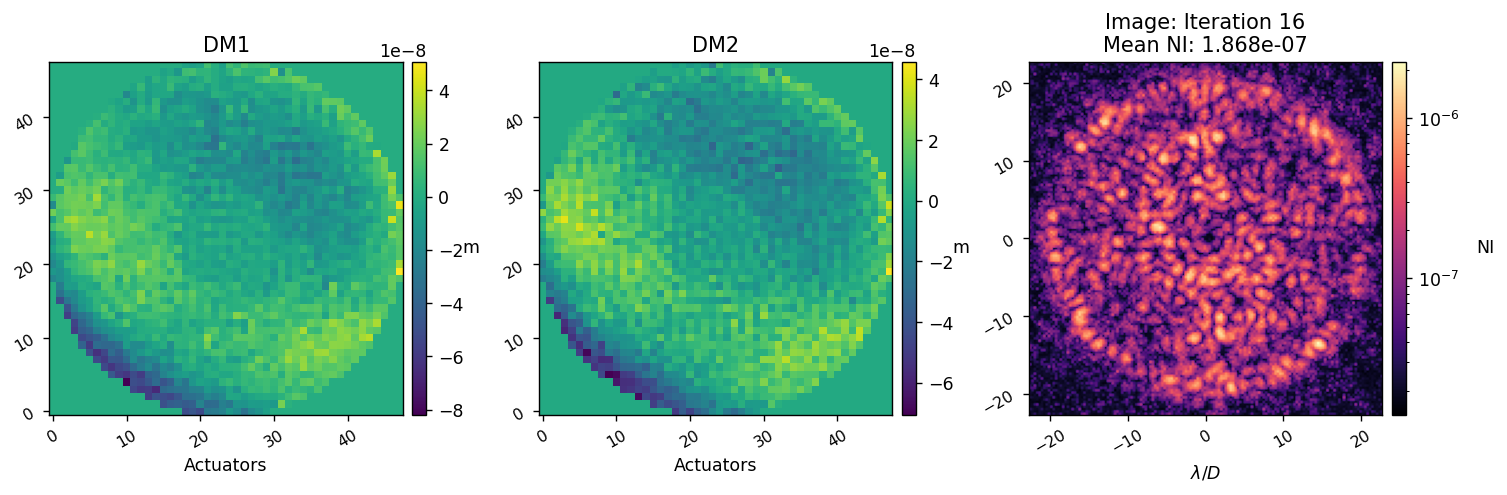

	Closed-loop iteration 17 / 18


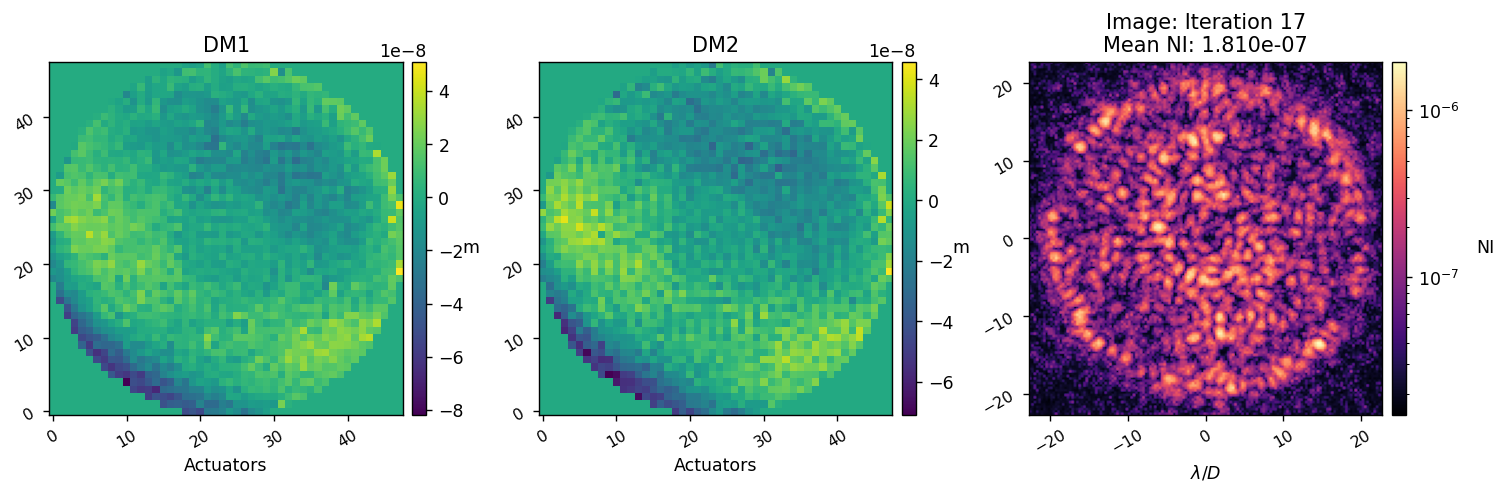

	Closed-loop iteration 18 / 18


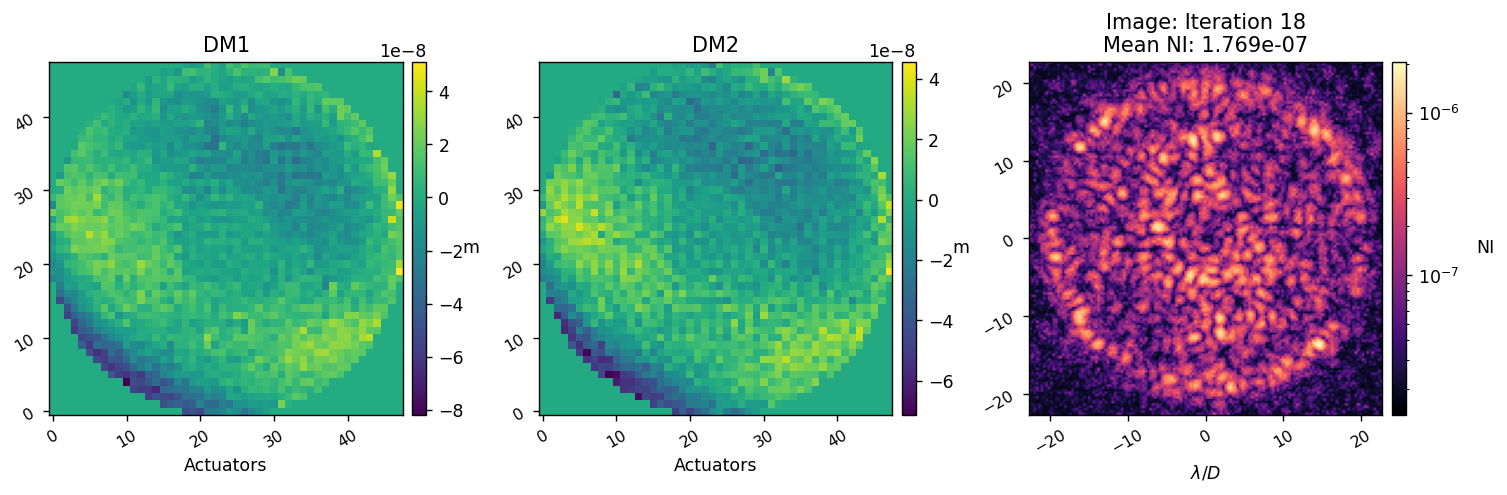

Closed loop for given control matrix completed in 23.450s.


In [48]:
reload(iefc_2dm)
reload(utils)

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        response_matrix,
                                                        reg_fun, reg_conds, 
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                                                        probe_exp_time=3,
                                                        probe_nframes=10,
                                                        probe_em_gain=250,
                                                        metric_exp_time=7,
                                                        metric_nframes=10,
                                                        metric_em_gain=250,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                                        old_regs=regs,
                                              )

In [147]:
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_dm1_commands_{today}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_dm2_commands_{today}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_images_{today}.fits', images)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_regs_{today}.fits', regs)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_dm1_commands_20231221.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_dm2_commands_20231221.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_images_20231221.fits


AttributeError: 'list' object has no attribute 'get'